In [1]:
try:
    from openmdao.utils.notebook_utils import notebook_mode
except ImportError:
    !python -m pip install openmdao[notebooks]

# Using the Case Viewer

The CaseViewer is a tool view interactive viewing of recorded cases data in Jupyter notebooks.
This is currently an experimental feature of OpenMDAO but it's useful enough in its current state that we've included it in the package.

## Example: Queen Dido's Problem

Queen Dido's problem is an optimization problem that is also a legend about the founding of Carthage.
Supposedly Queen Dido was allowed all the land she could enclose within the hide of an ox.
Cutting the hide into very thin strips provided her with a long, but finite, length of "fencing."
What arrangement of this fencing provides the greatest possible enclosed area?

If we assume a straight egde along one side of the fence (such as a riverbank or shoreline), how should the fencing be arranged to capture the greatest possible area?

The following component takes the distance of the river bank, $L$, as well as the distance of the "fence posts" from the riverbank, $y$, and computes the enclosed area and the perimeter.

In [2]:
import openmdao.api as om
import numpy as np

In [3]:
class Fence(om.ExplicitComponent):

    def initialize(self):
        self.options.declare('n', types=int, default=50, desc='number of fenceposts')

    def setup(self):
        n = self.options['n']
        self.add_input('L', val=10.0, units='m')
        self.add_input('y', val=np.zeros(n), units='m')

        self.add_output('perimeter', val=0.0, units='m')
        self.add_output('area', val=0.0, units='m**2')
        self.add_output('x', val=np.linspace(0, 100, n), units='m')

        self.declare_partials(of='*', wrt='*', method='cs')

    def compute(self, inputs, outputs):
        n = self.options['n']
        L = inputs['L']
        y = inputs['y']

        x = np.linspace(0, L, n)

        dx = x[1:] - x[:-1]
        dy = y[1:] - y[:-1]

        mean_y = 0.5 * (y[1:] + y[:-1])

        outputs['perimeter'] = np.sum(np.sqrt(dx**2+dy**2))
        outputs['area'] = np.sum(dx * mean_y)
        outputs['x'] = x

The optimization problem is to arrange these fence posts such that the perimeter $p$ does not exceed some value while maximizing the enclosed area $A$.

In addition, the first and last fenceposts should be placed along the river's edge.

\begin{align}
\mathrm{Minimize}\;J &= -A \\
\mathrm{Subject\;to:} \\
& 0 \le y_i \quad \mathrm{for} \quad i=1 ... N \\
& y[0] = 0 \; \mathrm{m}\\
& y[N] = 0 \; \mathrm{m}\\
& p = 300 \; \mathrm{m}
\end{align}

In [4]:
import matplotlib.pyplot as plt

def plot_fence(p, idx=0, fig=None, axes=None):
    if axes is None:     
        fig, axes = plt.subplots(3, 1, figsize=(12, 6), tight_layout=True, sharex=True)
#     axes[idx].set_aspect('equal')
    # ax.set_facecolor('tab:green')
    axes[idx].plot(p.get_val('fence.x'), p.get_val('fence.y'), 'ko-')
    axes[idx].fill_between(p.get_val('fence.x'), p.get_val('fence.y'), color='tab:green')
    axes[idx].fill_between([-1, 12], [-2, -2], color='tab:blue')
    A = p.get_val('fence.area', units='m**2')[0]
    perimeter = p.get_val('fence.perimeter', units='m')[0]
    L = p.get_val('fence.L', units='m')[0]
    axes[idx].annotate(f'p = {perimeter:6.2f} $m$', (4, 2.5), fontsize=16, color='white')
    axes[idx].annotate(f'A = {A:6.2f} $m^2$', (4, 0.5), fontsize=16, color='white')
    ht = -1
    w = L
    axes[idx].annotate('', xy=(0, ht), xytext=(w, ht), textcoords=axes[idx].transData, arrowprops=dict(arrowstyle='<->', color='white'))
    axes[idx].annotate('', xy=(0, ht), xytext=(w, ht), textcoords=axes[idx].transData, arrowprops=dict(arrowstyle='|-|', color='white'))
    bbox=dict(fc='tab:blue', ec='none')
    axes[idx].text(w/2, ht, f'L={L:6.2f} m', ha='center', va='center', color='white', fontsize=16, bbox=bbox)
    return fig, axes


/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/options_dictionary.py:332: OMDeprecationWarning:'gradient method' is not a valid python name and will become an invalid option name in a future release. You can prevent this warning (and future exceptions) by declaring this option using a valid python name.


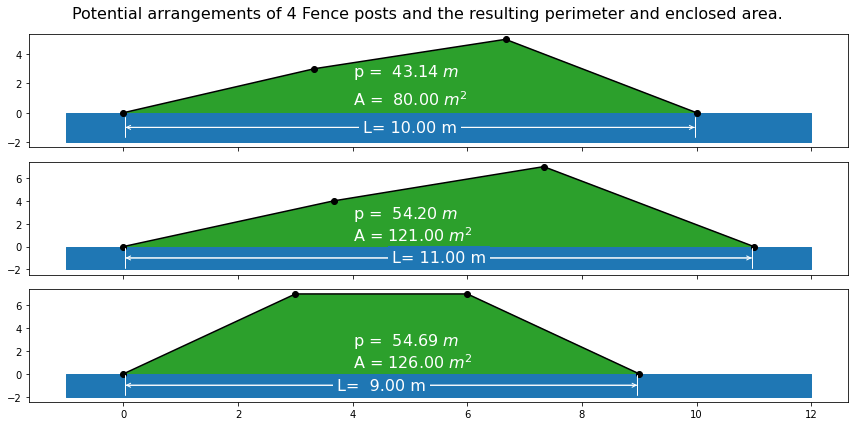

In [5]:
N = 4

prob = om.Problem()

prob.model.add_subsystem('fence', Fence(n=N))

prob.model.add_design_var('fence.L', lower=1)
prob.model.add_design_var('fence.y', lower=0, indices=om.slicer[1:-1])
prob.model.add_constraint('fence.perimeter', equals=100 * np.pi, ref=100 * np.pi)
prob.model.add_objective('fence.area', ref=-1000.0)

prob.driver = om.pyOptSparseDriver(optimizer='SLSQP')

prob.setup(force_alloc_complex=True)

prob.set_val('fence.L', val=10)

fig = None
axes = None

for i, inp in enumerate(((10, [0, 3, 5, 0]),
                         (11, [0, 4, 7, 0]),
                         (9, [0, 7, 7, 0]))):
    L, ys = inp
    prob.set_val('fence.L', val=L)
    prob.set_val('fence.y', val=ys)
    prob.run_model()
    fig, axes = plot_fence(prob, idx=i, fig=fig, axes=axes)

fig.suptitle('Potential arrangements of 4 Fence posts and the resulting perimeter and enclosed area.', fontsize=16)
plt.show()

## Solving the Optimization Problem and Recording the Driver Iterations

In the following code, we set up the optimziation problem to find the location of 20 fence posts which maximize area while limiting perimieter to $300$ meters.
A recorder is added to the driver that records the design variables, constraints, and objectives.

In [6]:
N = 20
p = om.Problem()

p.model.add_subsystem('fence', Fence(n=N))

p.model.add_design_var('fence.L', lower=1)
p.model.add_design_var('fence.y', lower=0, indices=om.slicer[1:-1])
p.model.add_constraint('fence.perimeter', equals=100 * np.pi, ref=100 * np.pi)
p.model.add_objective('fence.area', ref=-1000.0)

p.driver = om.pyOptSparseDriver(optimizer='SLSQP')

p.driver.add_recorder(om.SqliteRecorder('driver_cases.db'))
p.driver.recording_options['includes'] = ['*']
p.driver.recording_options['record_desvars'] = True
p.driver.recording_options['record_constraints'] = True
p.driver.recording_options['record_objectives'] = True

p.setup(force_alloc_complex=True)

p.set_val('fence.y', val=np.zeros(N))

p.run_driver();

/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/options_dictionary.py:332: OMDeprecationWarning:'gradient method' is not a valid python name and will become an invalid option name in a future release. You can prevent this warning (and future exceptions) by declaring this option using a valid python name.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/recorders/sqlite_recorder.py:228: UserWarning:The existing case recorder file, driver_cases.db, is being overwritten.
/Users/rfalck/anaconda3/envs/py39/lib/python3.9/site-packages/pyoptsparse/pyOpt_optimization.py:234: UserWarning: The argument `type=` is deprecated. Use `varType` in the future.
  warnings.warn("The argument `type=` is deprecated. Use `varType` in the future.")




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    0.1769
       User Objective Time :       0.0557
       User Sensitivity Time :     0.0980
       Interface Time :            0.0179
       Opt Solver Time:            0.0052
    Calls to Objective Function :      35
    Calls to Sens Function :           32


   Objectives
      Index  Name                  Value
          0  fence.area    -8.218499E-01

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name         Type      Lower Bound            Value      Upper Bound     Status
          0  fence.L_0       c     1.000000E+00     1.069717E+01     1.000000E+30           
          1  fence.y_0       c     0.000000E+00     2.185646E+00     1.000000E+30           
          2  fence.y_1       c     0.000000E+00     3.139145E+00     1.000000E+30  

In [7]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p.get_val('fence.area'), 821.85, tolerance=1.0E-2)

1.21185263400333e-07

## Invoking the CaseViewer

In the following line we invoke the CaseViewer.
It will not be displayed in the static documentation here, but executing this notebook in Jupyter will provide a GUI like that shown in the figure below.

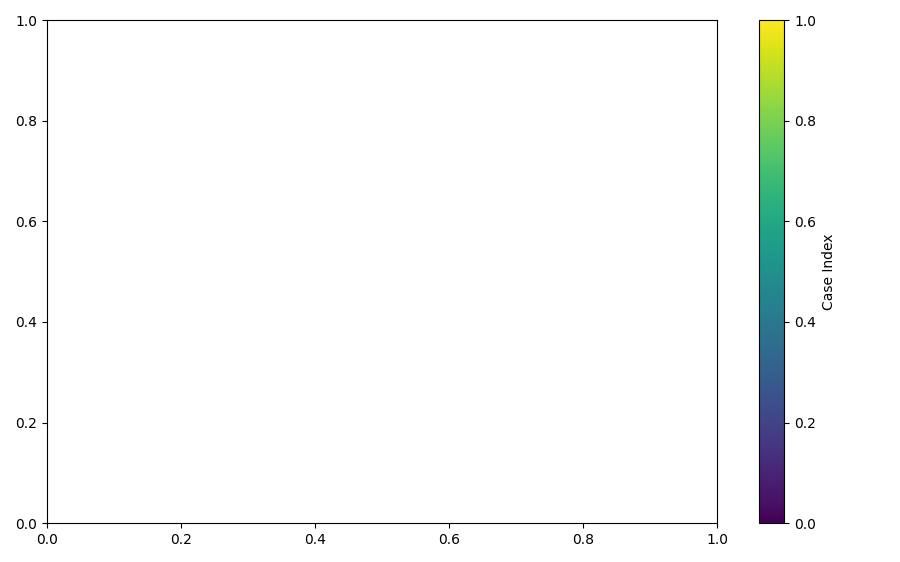

In [8]:
om.CaseViewer('driver_cases.db');

## Plotting a scalar vs. the case index

To see how the value of a variable evolves over the iteration history, use `Case Index` as the X-Axis variable.

For instance, to see how the area (the objective function) changes over iterations, choose `outputs -> fence.area` as the Y-Axis variable.

![Figure 1](./images/case_viewer_area.png)

## Plotting an array vs. the case index

When an array-valued variable is plotted against the Case Index, each value in the array is plotted at the X-Axis value corresponding to each case.
The color of each point represents its index in the array, with warmer colors being higher indices.

For instance, to see how the values of `fence.y` at each iteration, choose `inputs -> fence.y` as the Y-Axis variable.

If this type of plot is too noisy for your data, you can use the `Y Transform` options to retrieve things like the maximum value in the array, the minimum value in the array, or the norm of the array.

![Figure 2](./images/case_viewer_y_vs_case.png)

## Plotting one array vs. another

Sometimes it's useful to visualize the evolution of a solution as the plot of one array-shaped variable vs. another.
In our case, the shape of the fence is represented by plotting `outputs -> fence.x` on the X-Axis and `inputs -> fence.y` on the Y-Axis.


When plotting arrays, the X-Axis is required to be viewable as a flattened array.
The Y-Axis variable must have the same number of points as the X-Axis variable in its first dimension.
In our use-case here, `fence.x` and `fence.y` have the same shape.
If they did not, then the slice text boxes could be used to reshape the variable in the appropriate way.
The default value, `[...]`, plots the entire array.

When plotting one array vs. another, the CaseViewer will connect the points in each case using a line, and color that line based on the index of the case in the selected cases box at the top of the GUI.
Scrolling the slider will highlight a particular case.

![Figure 1](./images/case_viewer_x_vs_y.png)

## Current limitations of the CaseViewer

CaseViewer is currently limited to one instance per notebook.  Instantiating more than one will cause the plotting interface to fail.